**Data set:** https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data

**Target Variable:**
stroke: Binary variable indicating whether having stroke (1) or No stroke (0).


### **Problem Definition:**

The task is to develop a predictive model to determine the likelihood of a patient experiencing a stroke based on various input parameters. Given a dataset containing information such as gender, age, presence of hypertension, heart disease, marital status, occupation, residence type, average glucose level, body mass index (BMI), and smoking status, the objective is to predict whether a patient is susceptible to a stroke or not.The problem can be formulated as a binary classification task, where the target variable is whether a stroke occurred (1) or not (0). The model will be trained on historical data with known stroke outcomes to learn patterns and relationships between the input features and stroke incidence. Once trained, the model will be capable of predicting the likelihood of stroke for new, unseen patient data.This predictive model can potentially aid healthcare professionals in identifying individuals at higher risk of stroke, allowing for timely intervention and preventive measures to reduce the burden of stroke-related morbidity and mortality.


### **Business Problem and Implications:**

The business problem that can be addressed using the stroke prediction dataset revolves around the healthcare sector's need to enhance stroke prevention strategies. This challenge primarily affects healthcare providers, insurance companies, patients, and their families. For healthcare providers and insurance companies, the early identification of high-risk patients enables the implementation of targeted preventative measures, potentially leading to significant cost savings by reducing the need for expensive emergency treatments and long-term care associated with stroke recovery. For patients and their families, the implications are profoundly personal; early intervention can mean the difference between life and death, significantly reduce the severity of a stroke's aftermath, or even prevent the occurrence entirely.

The financial implications of a potential solution include reduced healthcare costs associated with treating stroke and its long-term effects, such as rehabilitation and disability accommodations. Furthermore, insurance companies could see lower payout rates for stroke-related claims by investing in preventive care and personalized health monitoring for high-risk individuals. Socially, the benefits are immense; improved quality of life for those at risk, reduced emotional and financial strain on families, and a healthier population overall. Moreover, by leveraging such analytics, public health initiatives can be more effectively directed, and awareness campaigns can be tailored to those at the highest risk, fostering a more health-conscious society.

### **Objective:**

The objective of this project is to develop a predictive model to identify individuals who are at risk of experiencing a stroke based on their demographic information, medical history, and lifestyle factors. By analyzing a dataset containing features such as gender, age, presence of various diseases, smoking status, and other relevant parameters, the goal is to build a robust machine learning model that can accurately classify individuals as either high or low risk for stroke.


In [0]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import pandas as pd
import seaborn as sns
import pyspark.pandas as ps
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.sql.functions import col
from sklearn.metrics import roc_curve, auc, silhouette_score
from pyspark.ml.feature import StringIndexer, OneHotEncoder, MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster



In [0]:
strokedetection = spark.read.table('default.healthcare_dataset_stroke_data')


In [0]:
strokedetection.show(5
                     )

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [0]:
target_distribution = strokedetection.groupBy('stroke').count()
target_distribution.show()

+------+-----+
|stroke|count|
+------+-----+
|     1|  249|
|     0| 4861|
+------+-----+



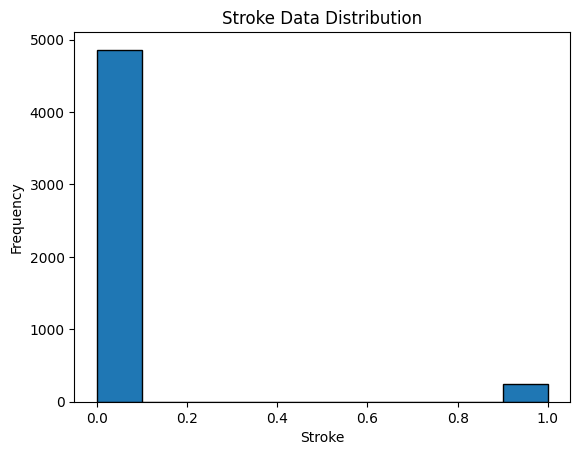

In [0]:
stroke_data_pd = strokedetection.select('stroke').toPandas()

plt.hist(stroke_data_pd['stroke'], bins=10, edgecolor='black')
plt.xlabel('Stroke')
plt.ylabel('Frequency')
plt.title('Stroke Data Distribution')
plt.show()

The graphs illustrate the relationship with the target variable "Stroke."

Upon examination, it's clear that the distribution of stroke cases skews heavily towards negative outcomes. Specifically, there are approximately 4861 instances of negative outcomes compared to only 249 instances of positive results.

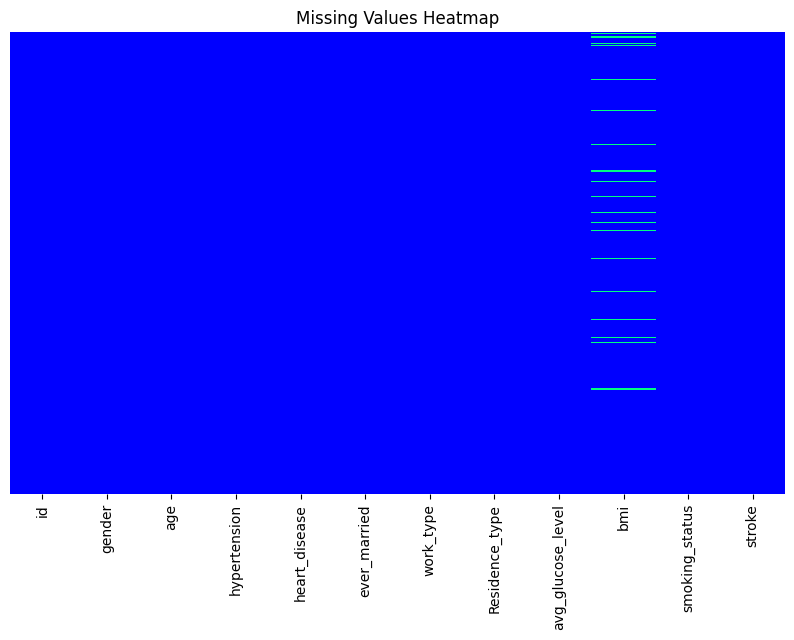

In [0]:
# Looking for Values are NULL, NaN, or 'N/A'
missing = strokedetection.select(
    [F.when(F.col(column).isNull() | F.isnan(F.col(column)) | (F.col(column) == "N/A"), 1).otherwise(0).alias(column)
     for column in strokedetection.columns]
)
missing_df = missing.toPandas()

plt.figure(figsize=(10, 6))
sns.heatmap(missing_df, cbar=False, cmap="winter", yticklabels=False)

# Display the plot
plt.title("Missing Values Heatmap")
plt.show()


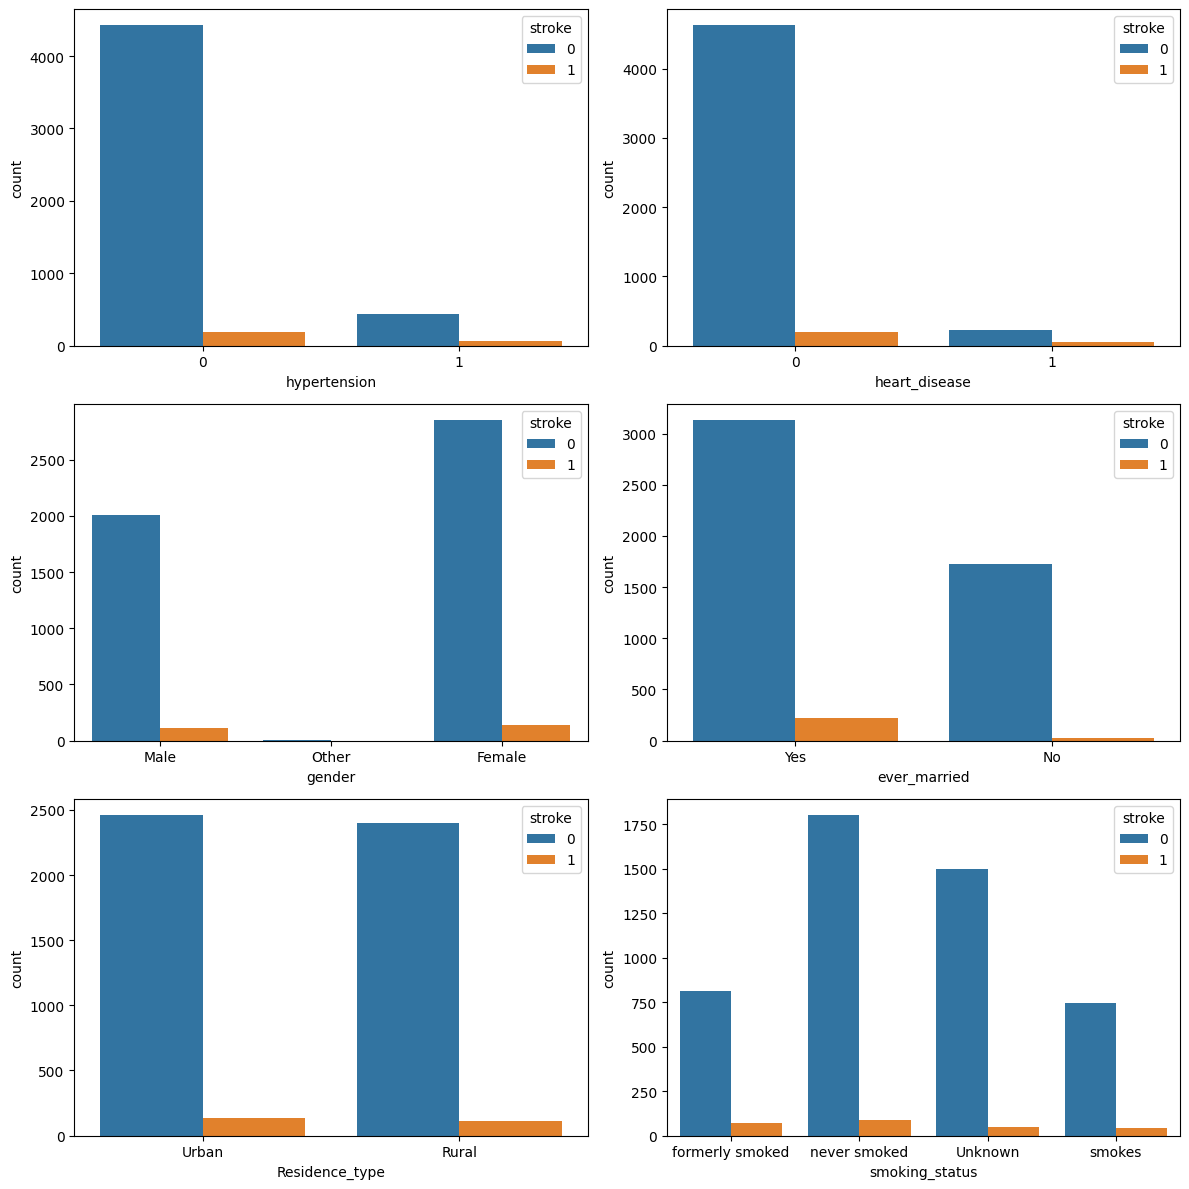

In [0]:
# Bar chart for binary variables
binary_vars = ['hypertension', 'heart_disease', 'gender', 'ever_married', 'Residence_type', 'smoking_status']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
for var, ax in zip(binary_vars, axes.flatten()):
    group_df = strokedetection.groupBy(var, 'stroke').count().toPandas()
    sns.barplot(x=var, y='count', hue='stroke', data=group_df, ax=ax)

plt.tight_layout()
plt.show()


The graphs illustrate the relationship between the target variable "Stroke" along with the distribution of variables like Hypertension, Heart_disease, Gender, Ever_married, Residence_type, and Smoking_status concerning the target variable.

It is evident from all graphs that these variables exhibit sparse distributions, predominantly impacting a negative outcome of Stroke. A closer examination of the graphs depicting positive stroke outcomes reveals a higher risk associated with certain demographics and health conditions. Specifically, the risk of stroke appears elevated among married individuals, women, urban residents, and those with heart disease. These distinctions are clearly depicted in the graphical representations.


In [0]:
strokedetection = strokedetection.withColumn("bmi", F.when(F.col("bmi") == "N/A", None).otherwise(F.col("bmi")))
strokedetection = strokedetection.withColumn("bmi", F.col("bmi").cast("double"))
median_bmi = strokedetection.approxQuantile("bmi", [0.5], 0.0)[0]
strokedetection = strokedetection.fillna({'bmi': median_bmi})


strokedetection.show(10)



+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|28.1|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

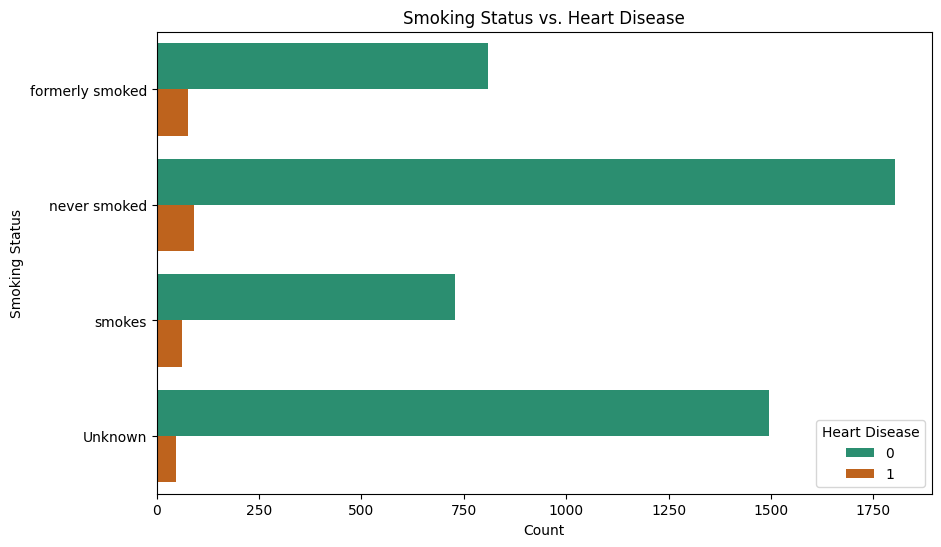

In [0]:
pandas_df = strokedetection.select("smoking_status", "heart_disease").toPandas()

plt.figure(figsize=(10, 6))
sns.countplot(y='smoking_status', hue='heart_disease', data=pandas_df, palette='Dark2')

plt.xlabel('Count')
plt.ylabel('Smoking Status')
plt.title('Smoking Status vs. Heart Disease')
plt.legend(title='Heart Disease', loc='lower right')

plt.show()


The graphs depict the relationship between the target variable "Stroke" and the distribution of the "Heart_disease" variable concerning the target.

Observing the data, it's notable that both the Stroke variable and Heart disease show a higher distribution of negative outcomes. However, the risk for a positive outcome is more apparent among individuals who have never smoked or were former smokers.

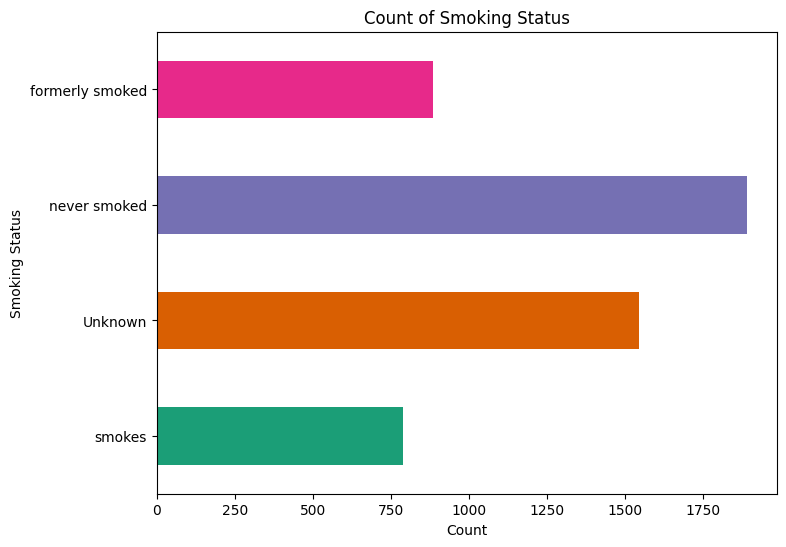

In [0]:

grouped_data = strokedetection.groupBy("smoking_status").count()

pandas_df = grouped_data.toPandas()


plt.figure(figsize=(8, 6))
pandas_df.set_index('smoking_status')['count'].plot(kind='barh', color=sns.color_palette('Dark2'))

plt.xlabel("Count")
plt.ylabel("Smoking Status")
plt.title("Count of Smoking Status")
plt.show()


The graphs illustrate the relationship with the predictor variable "Smoking status."

Upon observation, it's noteworthy that the dataset contains a higher number of rows with the "Never smoked" status. Interestingly, regarding the distribution of the target variable, this predictor variable appears to have a more significant influence on positive stroke outcomes.

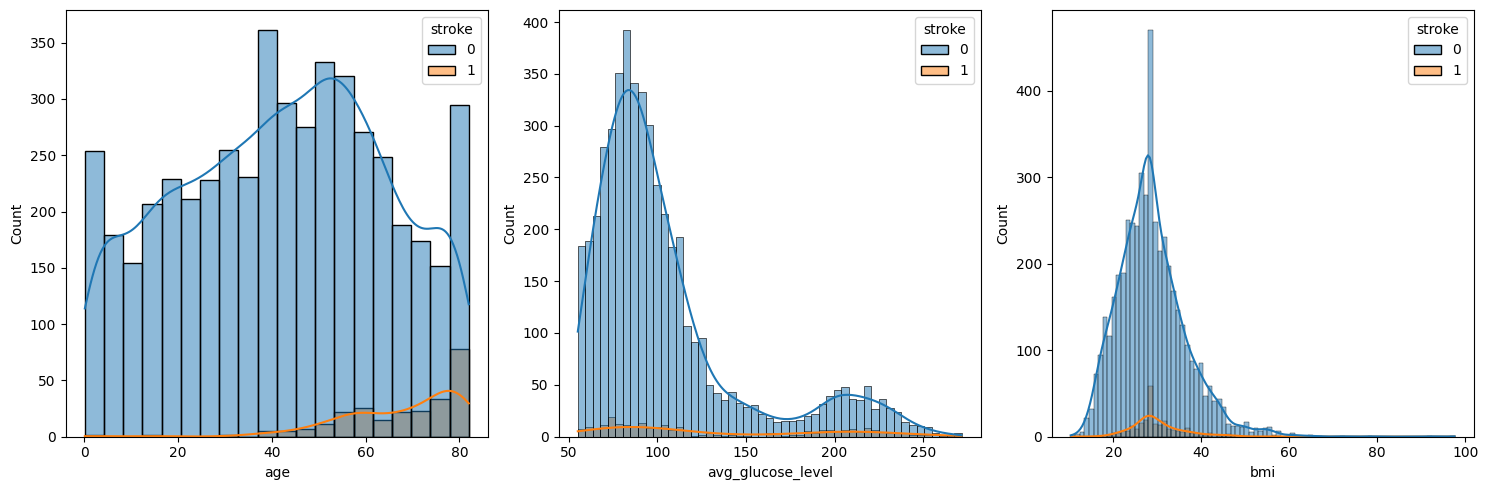

In [0]:

pandas_df = strokedetection.select("age", "avg_glucose_level", "bmi", "stroke").toPandas()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

continuous_vars = ['age', 'avg_glucose_level', 'bmi']

for var, ax in zip(continuous_vars, axes.flatten()):
    sns.histplot(data=pandas_df, x=var, hue='stroke', ax=ax, kde=True)

plt.tight_layout()
plt.show()


The graphs above illustrate the relationship between the target variable and predictor variables, highlighting how Age, Avg_glucose_level, and BMI are distributed based on the target variable.

Upon closer inspection, it's evident that these variables display sparse distributions, predominantly influencing a negative outcome of stroke. However, a more detailed analysis of the graphs portraying positive stroke outcomes reveals a heightened risk associated with specific demographics and health conditions. Particularly, the risk of stroke seems to increase among individuals aged 70 and older, those with Avg_glucose_level around 65-75, and BMI around 30. These distinctions are clearly depicted in the graphical representations.

Conversely, concerning adverse effects, individuals around the age of 45 exhibit the highest percentage of risk for not experiencing a stroke.

In [0]:
# Dropping uneccesary 
strokedetection = strokedetection.drop('id')
strokedetection = strokedetection.filter(~strokedetection["smoking_status"].isin(['Unknown']))
strokedetection = strokedetection.filter(strokedetection['bmi'] <= 65)
strokedetection.show(10)


+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|28.1|   never smoked|     1|
|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
|Female|79.0|           1|            0|         Yes|Self-employed|         Rural|           174.

In [0]:

categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_ohe") for col in categorical_cols]
pipeline = Pipeline(stages=indexers + encoders)
strokedetection_encoded = pipeline.fit(strokedetection).transform(strokedetection)

strokedetection_encoded.show(10)


+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+------------+------------------+---------------+--------------------+--------------------+-------------+----------------+-------------+------------------+------------------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|gender_index|ever_married_index|work_type_index|Residence_type_index|smoking_status_index|   gender_ohe|ever_married_ohe|work_type_ohe|Residence_type_ohe|smoking_status_ohe|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+------------+------------------+---------------+--------------------+--------------------+-------------+----------------+-------------+------------------+------------------+
|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           2

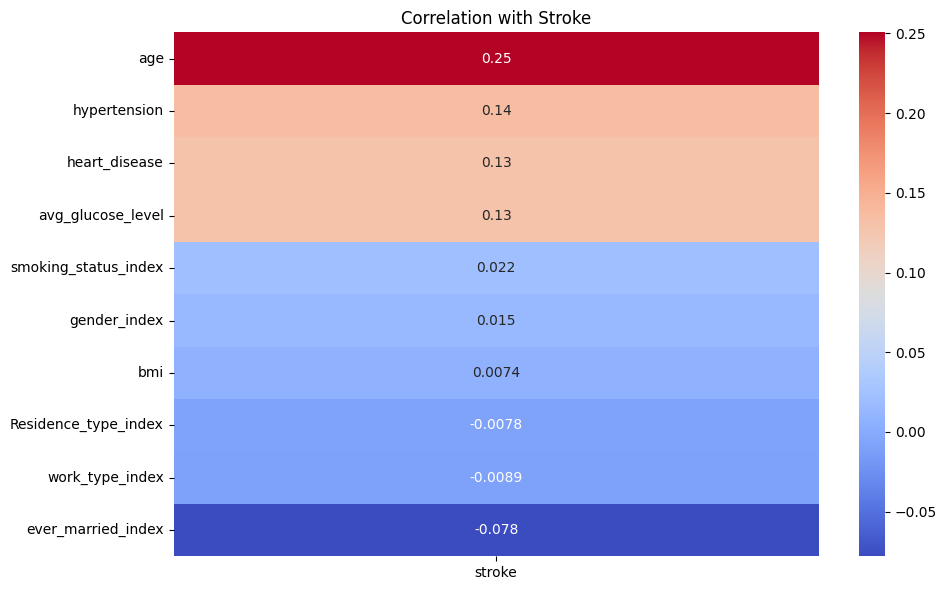

In [0]:
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_cols]
pipeline = Pipeline(stages=indexers)
strokedetection_encoded = pipeline.fit(strokedetection).transform(strokedetection)

continuous_vars = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']
indexed_categorical_vars = [col + "_index" for col in categorical_cols]

all_vars = continuous_vars + indexed_categorical_vars

correlations = {}
for col in all_vars:
    corr_value = strokedetection_encoded.stat.corr(col, 'stroke') 
    correlations[col] = corr_value



corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['stroke'])
sorted_corr_df = corr_df.sort_values(by='stroke', ascending=False)

plt.figure(figsize=(10, 6))
corr_plot = sns.heatmap(sorted_corr_df, annot=True, cmap='coolwarm')

plt.title('Correlation with Stroke')
plt.tight_layout()
plt.show()


In [0]:
columns_to_corr = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease', 
                   'gender_index', 'ever_married_index', 'work_type_index', 'Residence_type_index', 'smoking_status_index']

correlations = {}

for col in columns_to_corr:
    corr_value = strokedetection_encoded.stat.corr(col, 'stroke')  
    correlations[col] = corr_value

corr_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['correlation_with_stroke'])
sorted_corr_df = corr_df.sort_values(by='correlation_with_stroke', ascending=False)
print(sorted_corr_df)


                      correlation_with_stroke
age                                  0.250724
hypertension                         0.135327
heart_disease                        0.129299
avg_glucose_level                    0.128845
smoking_status_index                 0.021693
gender_index                         0.015454
bmi                                  0.007419
Residence_type_index                -0.007803
work_type_index                     -0.008873
ever_married_index                  -0.078074


/databricks/python/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


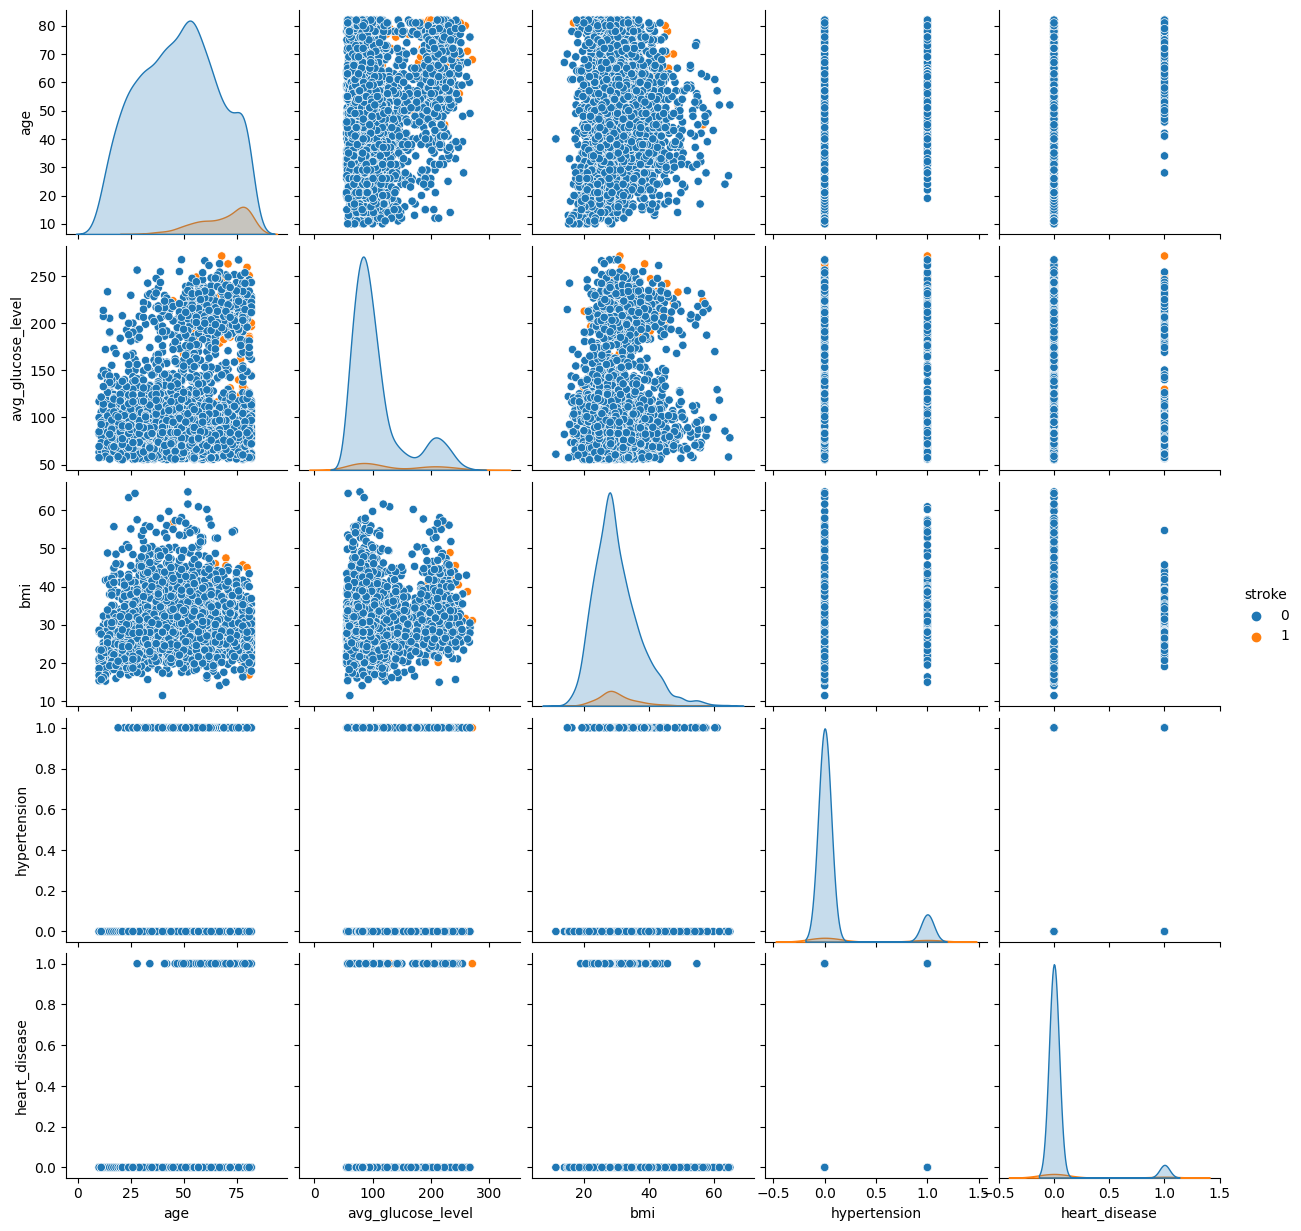

In [0]:
visualize = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease', 'stroke']
pandas_df = strokedetection_encoded.select(visualize).toPandas()
sns.pairplot(pandas_df, hue='stroke')
plt.show()


In [0]:
strokedetection.describe().show(10)

+-------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+-----------------+---------------+-------------------+
|summary|gender|               age|       hypertension|      heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|              bmi| smoking_status|             stroke|
+-------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+-----------------+---------------+-------------------+
|  count|  3563|              3563|               3563|               3563|        3563|     3563|          3563|              3563|             3563|           3563|               3563|
|   mean|  NULL|48.866124052764526|0.12461408925063149|0.06399101880437834|        NULL|     NULL|          NULL|108.97907381420114|30.16160538871741|           NULL|0.05669379736177379|
| stddev|  NULL| 18.87612281910579|0.33032717535391115|0.24477128

In [0]:
target_distribution = strokedetection.groupBy('stroke').count()
target_distribution.show()


+------+-----+
|stroke|count|
+------+-----+
|     1|  202|
|     0| 3361|
+------+-----+



In [0]:
strokedetection.show(10)

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|28.1|   never smoked|     1|
|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
|Female|79.0|           1|            0|         Yes|Self-employed|         Rural|           174.

In [0]:
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numeric_cols = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']


indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_cols]
assembler = VectorAssembler(inputCols=[col + "_index" for col in categorical_cols] + numeric_cols, outputCol="features")
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
pipeline = Pipeline(stages=indexers + [assembler, scaler])


scaled_model = pipeline.fit(strokedetection)
strokedetection_scaled = scaled_model.transform(strokedetection)

strokedetection_scaled.select("scaledFeatures", "stroke").show(5)


+--------------------+------+
|      scaledFeatures|stroke|
+--------------------+------+
|[0.5,0.0,0.0,0.0,...|     1|
|(10,[2,3,5,6,7],[...|     1|
|[0.5,0.0,0.0,1.0,...|     1|
|(10,[4,5,6,7],[1....|     1|
|[0.0,0.0,0.25,1.0...|     1|
+--------------------+------+
only showing top 5 rows



In [0]:
strokedetection_scaled.select("scaledFeatures", "stroke").show(5)


+--------------------+------+
|      scaledFeatures|stroke|
+--------------------+------+
|[0.5,0.0,0.0,0.0,...|     1|
|(10,[2,3,5,6,7],[...|     1|
|[0.5,0.0,0.0,1.0,...|     1|
|(10,[4,5,6,7],[1....|     1|
|[0.0,0.0,0.25,1.0...|     1|
+--------------------+------+
only showing top 5 rows



Logistic Regression


In [0]:
train_data, test_data = strokedetection_scaled.randomSplit([0.7, 0.3], seed=42)

In [0]:
X_train = train_data.select("scaledFeatures")
y_train = train_data.select("stroke")

X_test = test_data.select("scaledFeatures")
y_test = test_data.select("stroke")

+------+----------+-----+
|stroke|prediction|count|
+------+----------+-----+
|     1|       0.0|   68|
|     0|       0.0|  944|
+------+----------+-----+

Accuracy: 0.932806324110672
Precision: 0.870127638300864
Recall: 0.932806324110672
F1 Score: 0.900377474397213
AUC: 0.83


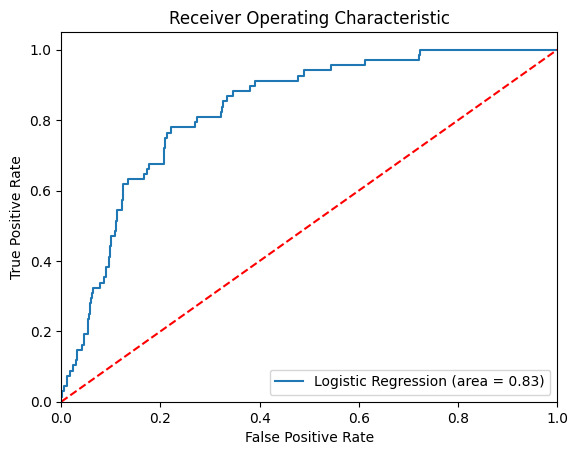

In [0]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col
from sklearn.metrics import roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt


lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="stroke")
lr_model = lr.fit(train_data)


predictions = lr_model.transform(test_data)


conf_matrix = predictions.groupBy("stroke", "prediction").count()
conf_matrix.show()


accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="f1")

# Calculate metrics
accuracy = accuracy_evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1 = f1_evaluator.evaluate(predictions)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


preds_and_labels = predictions.select(col("probability"), col("stroke")).collect()
preds_and_labels = [(float(prob[1]), float(label)) for prob, label in preds_and_labels]
probs, labels = zip(*preds_and_labels)

preds_df = pd.DataFrame({'probability': probs, 'label': labels})
fpr, tpr, thresholds = roc_curve(preds_df['label'], preds_df['probability'])
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.2f}")

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')   
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [0]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(featuresCol='scaledFeatures').setK(2).setSeed(1)
model = kmeans.fit(strokedetection_scaled.select('scaledFeatures'))
transformed = model.transform(strokedetection_scaled)
transformed.select('scaledFeatures', 'prediction').show()
cluster_analysis = transformed.groupBy('prediction').mean().toPandas()

print(cluster_analysis)


+--------------------+----------+
|      scaledFeatures|prediction|
+--------------------+----------+
|[0.5,0.0,0.0,0.0,...|         1|
|(10,[2,3,5,6,7],[...|         0|
|[0.5,0.0,0.0,1.0,...|         0|
|(10,[4,5,6,7],[1....|         1|
|[0.0,0.0,0.25,1.0...|         0|
|(10,[0,4,5,6,7],[...|         1|
|[0.5,0.0,0.0,1.0,...|         0|
|(10,[1,5,6,7],[1....|         1|
|(10,[3,5,6,7,8],[...|         0|
|[0.0,0.0,0.5,1.0,...|         0|
|(10,[4,5,6,7],[1....|         1|
|(10,[5,6,7,9],[0....|         1|
|[0.0,0.0,0.25,1.0...|         0|
|[0.5,0.0,0.0,0.0,...|         1|
|[0.5,0.0,0.0,0.0,...|         1|
|(10,[1,5,6,7],[1....|         1|
|[0.0,0.0,0.5,1.0,...|         0|
|(10,[2,5,6,7,8],[...|         1|
|(10,[2,5,6,7],[0....|         1|
|(10,[0,4,5,6,7],[...|         1|
+--------------------+----------+
only showing top 20 rows

   prediction   avg(age)  ...  avg(smoking_status_index)  avg(prediction)
0           1  49.209597  ...                   0.720905              1.0
1         

In [0]:

def evaluated_kmeans(k_values, data, features_col):
    for k in k_values:
        kmeans = KMeans(featuresCol=features_col, k=k, seed=1)
        model = kmeans.fit(data)
        transformed = model.transform(data)
        
        evaluator = ClusteringEvaluator(featuresCol=features_col)
        silhouette_score = evaluator.evaluate(transformed)
        
        print(f"K = {k}, Silhouette Score: {silhouette_score}")

evaluated_kmeans(range(2, 11), strokedetection_scaled, 'scaledFeatures')

K = 2, Silhouette Score: 0.4107390578583
K = 3, Silhouette Score: 0.42709872587929115
K = 4, Silhouette Score: 0.42276469408148004
K = 5, Silhouette Score: 0.39330746499497765
K = 6, Silhouette Score: 0.4268327813367648
K = 7, Silhouette Score: 0.41082639870817583
K = 8, Silhouette Score: 0.44575088539784086
K = 9, Silhouette Score: 0.4620432481695236
K = 10, Silhouette Score: 0.4570320032842741


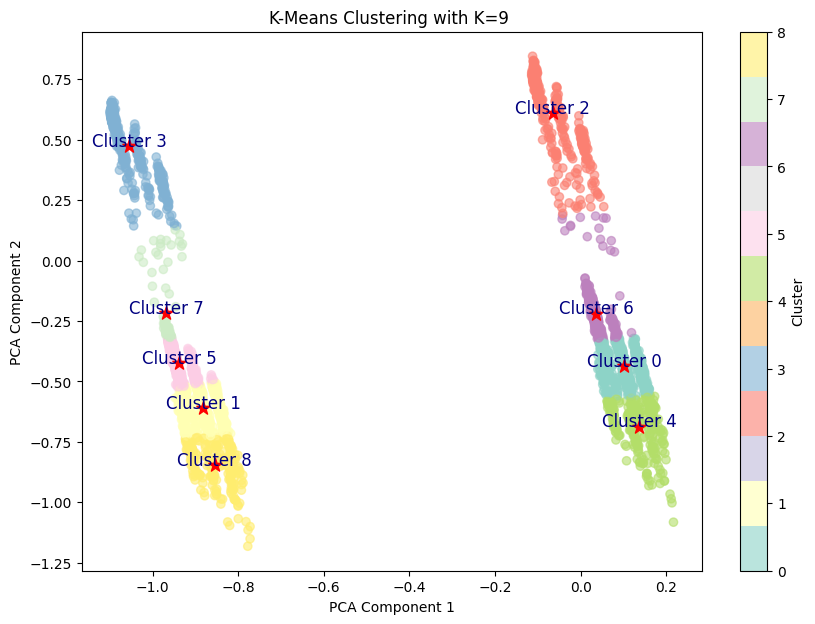

In [0]:
from pyspark.ml.feature import PCA
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(strokedetection_scaled)
strokedetection_pca = pca_model.transform(strokedetection_scaled)

kmeans = KMeans(featuresCol="pcaFeatures", k=9, seed=1)
model = kmeans.fit(strokedetection_pca)
transformed_pca = model.transform(strokedetection_pca)


pca_features = transformed_pca.select("pcaFeatures", "prediction").collect()
x_pca = [row['pcaFeatures'][0] for row in pca_features]
y_pca = [row['pcaFeatures'][1] for row in pca_features]
cluster_labels = [row['prediction'] for row in pca_features]
centers = np.array(model.clusterCenters())


plt.figure(figsize=(10, 7))
scatter = plt.scatter(x_pca, y_pca, c=cluster_labels, cmap='Set3', marker='o', alpha=0.6)
plt.colorbar(scatter, label='Cluster')


for i, (x, y) in enumerate(centers):
    plt.scatter(x, y, color='red', marker='*', s=100)  
    plt.text(x, y, f'Cluster {i}', fontsize=12, ha='center', color='navy')  

# Set plot titles and labels
plt.title("K-Means Clustering with K=9 ")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


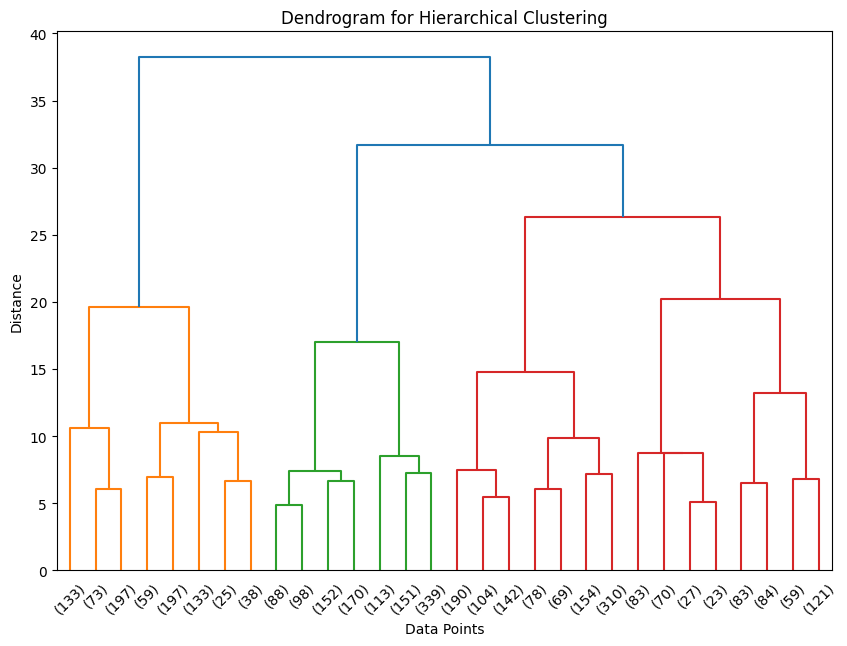

Cluster Counts:
3    1597
2    1111
1     855
Name: cluster, dtype: int64

Cluster Analysis (AVG of Each Feature per Cluster):
                0    1         2  ...         7         8         9
cluster                           ...                              
1        0.188304  1.0  0.155848  ...  0.313600  0.054971  0.029240
2        0.186769  0.0  0.136139  ...  0.357219  0.000000  0.000000
3        0.209768  0.0  0.134314  ...  0.364742  0.248591  0.127113

[3 rows x 10 columns]


In [0]:
features = strokedetection_scaled.select("scaledFeatures").collect()
features_df = pd.DataFrame([row['scaledFeatures'] for row in features])
Z = linkage(features_df, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(Z, truncate_mode='lastp', p=30)  
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()


cluster_labels = fcluster(Z, t=3, criterion='maxclust')
features_df['cluster'] = cluster_labels

print("Cluster Counts:")
print(features_df['cluster'].value_counts())


cluster_analysis = features_df.groupby('cluster').mean()
print("\nCluster Analysis (AVG of Each Feature per Cluster):")
print(cluster_analysis)

In [0]:
Z = linkage(features_df, method='ward')
silhouette_scores = {}
for t in range(3, 16):
    cluster_labels = fcluster(Z, t=t, criterion='maxclust')
    score = silhouette_score(features_df, cluster_labels)
    silhouette_scores[t] = score
    print(f"Number of clusters: {t}, Silhouette Score: {score}")



Number of clusters: 3, Silhouette Score: 0.3892922738374523
Number of clusters: 4, Silhouette Score: 0.39988206286588374
Number of clusters: 5, Silhouette Score: 0.4211021498591086
Number of clusters: 6, Silhouette Score: 0.40897367147635577
Number of clusters: 7, Silhouette Score: 0.34654539813081575
Number of clusters: 8, Silhouette Score: 0.28903377960704885
Number of clusters: 9, Silhouette Score: 0.2994986015178718
Number of clusters: 10, Silhouette Score: 0.2946842141989406
Number of clusters: 11, Silhouette Score: 0.29467196089232023
Number of clusters: 12, Silhouette Score: 0.2993887868907279
Number of clusters: 13, Silhouette Score: 0.30376725913669117
Number of clusters: 14, Silhouette Score: 0.3087984498017358
Number of clusters: 15, Silhouette Score: 0.31526859938568025


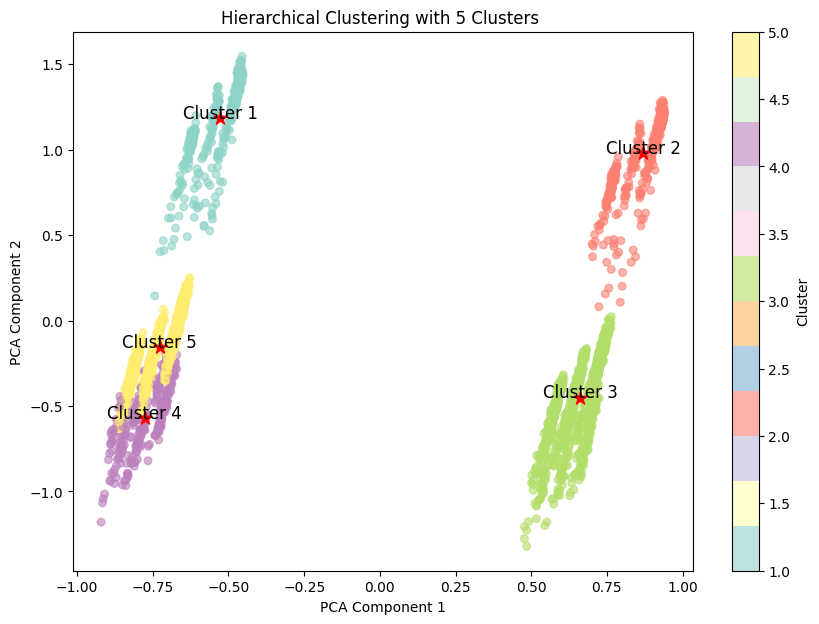

In [0]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
import pandas as pd

Z = linkage(features_df.drop(columns=['cluster'], errors='ignore'), method='ward')

cluster_labels = fcluster(Z, t=5, criterion='maxclust')
features_df['cluster'] = cluster_labels  


features_df.columns = features_df.columns.astype(str) 
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features_df.drop(columns=['cluster']))


features_df['pca1'] = pca_features[:, 0]
features_df['pca2'] = pca_features[:, 1]

centroids = features_df.groupby('cluster')[['pca1', 'pca2']].mean().values


plt.figure(figsize=(10, 7))
scatter = plt.scatter(features_df['pca1'], features_df['pca2'], c=features_df['cluster'], cmap='Set3', s=30, alpha=0.6)
plt.colorbar(scatter, label='Cluster')


for i, (x, y) in enumerate(centroids, 1):  
    plt.scatter(x, y, color='red', marker='*', s=100)  
    plt.text(x, y, f'Cluster {i}', fontsize=12, ha='center', color='black')  


plt.title("Hierarchical Clustering with 5 Clusters ")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


